### IMPORTACION DE LIBRERIAS

In [19]:
import torch
from torch import nn
# import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms.functional as TF
from keras.models import load_model
from PIL import Image
import numpy as np
import keras.utils as image
from os.path import join, exists
from os import listdir, makedirs
from keras.preprocessing.image import ImageDataGenerator
import time as t
import shutil
import psutil
import cv2
import gc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

## Importación de modelos UNet 1 - segmentación completa

In [3]:
class Conv_3_k(nn.Module):
    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in,channels_out, kernel_size=3,stride=1,padding=1)

    def forward(self, x ):
        return self.conv1(x)

class Double_Conv(nn.Module):

    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
            Conv_3_k(channels_in,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),

            Conv_3_k(channels_out,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2,2),
            Double_Conv(channels_in,channels_out)
        )
    def forward(self,x):
        return self.encoder(x)


class Up_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='bicubic'),
            nn.Conv2d(channels_in,channels_in//2,kernel_size=1,stride=1)
        )

        self.decoder = Double_Conv(channels_in,channels_out)

    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)
        x =  torch.cat([x2,x1],dim=1)
        return self.decoder(x)

class UNET_potato_model(nn.Module):


    def __init__(self, channels_in, channels, num_class ):
        super().__init__()
        self.f_conv = Double_Conv(channels_in, channels) # 16,256,256
        self.down_conv1 = Down_conv(channels, 2*channels) # 32, 128, 128
        self.down_conv2 = Down_conv(2*channels,4*channels) # 64, 64, 64

        self.middle_conv = Down_conv(4*channels,8*channels) # 128, 32 , 32

        self.up_conv1 = Up_conv(8*channels, 4*channels) # 64, 64 , 64
        self.up_conv2 = Up_conv(4*channels, 2*channels) # 32, 128, 128
        self.up_conv3 = Up_conv(2*channels, channels) # 16, 256, 256

        self.last_conv = nn.Conv2d(channels, num_class, kernel_size=1,stride=1)

    def forward(self, x):
        x1 = self.f_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)

        x4 = self.middle_conv(x3)

        x5 = self.up_conv1(x4,x3)
        x6 = self.up_conv2(x5,x2)
        x7 = self.up_conv3(x6,x1)


        return self.last_conv(x7)

In [4]:
model_UNET = UNET_potato_model(3, 16, 2)
PaTHs = 'D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/PRUEBAS/MODELO3_29_01_24.pt'
# model_UNET.load_state_dict(torch.load(PaTHs, map_location=torch.device('cpu'))) Habilitar esta línea si no se dispone de GPU
model_UNET.load_state_dict(torch.load(PaTHs))
model_UNET.eval()

UNET_potato_model(
  (f_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
         

## Importación de modelo UNet 2 - segmentación defectuosa

In [5]:
class UNET_potato_modelD(nn.Module):


    def __init__(self, channels_in, channels, num_class ):
        super().__init__()
        self.f_conv = Double_Conv(channels_in, channels) 
        self.down_conv1 = Down_conv(channels, 2*channels) 
        self.down_conv2 = Down_conv(2*channels,4*channels) 
        self.down_conv3 = Down_conv(4*channels,8*channels)

        self.middle_conv = Down_conv(8*channels,16*channels) 

        self.up_conv1 = Up_conv(16*channels, 8*channels)
        self.up_conv2 = Up_conv(8*channels, 4*channels)
        self.up_conv3 = Up_conv(4*channels, 2*channels)
        self.up_conv4 = Up_conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_class, kernel_size=1,stride=1)

    def forward(self, x):
        x1 = self.f_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        x6 = self.up_conv1(x5,x4)
        x7 = self.up_conv2(x6,x3)
        x8 = self.up_conv3(x7,x2)
        x9 = self.up_conv4(x8,x1)


        return self.last_conv(x9)

In [6]:
model_UNET_D2_1 = UNET_potato_modelD(3, 8, 3)
PaTHss = 'D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/PRUEBAS/MODELUNET2/UNETDEFECTV_2_new.pt'
model_UNET_D2_1.load_state_dict(torch.load(PaTHss))
model_UNET_D2_1.eval()

UNET_potato_modelD(
  (f_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
            (c

## Importación de clasificador CNN

In [8]:
MODEL_PR= "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/MODELOSAGRUPADOS/model_best_principa.h5"
model_7 =load_model(MODEL_PR)

## Funciones 

In [9]:
def segmentation_semantic_function(img_array):
#     imagen = Image.open(img_array).convert('RGB')
    imagen = Image.fromarray(np.uint8(img_array))
    transform = T.Compose([
    T.ToTensor()
    ])
    img_transform = transform(imagen).unsqueeze(0)
    with torch.no_grad():
        resultado = model_UNET(img_transform)
    probabilidades = torch.softmax(resultado, dim=1)
    clase_predicha = torch.argmax(probabilidades, dim=1).squeeze().numpy()
    imagen_pil = to_pil_image(img_transform.squeeze())
    mascara_binaria = (clase_predicha).astype(np.uint8)
    imagen_recortada = to_pil_image(to_tensor(imagen_pil) * mascara_binaria)
    result= np.array(imagen_recortada).astype('float64')
#     result = imagen_recortada.astype('float64')
    return result

### PARA HACER PRUEBAS

In [10]:
test_datagen =ImageDataGenerator(rescale=1./255, preprocessing_function=segmentation_semantic_function)

In [11]:
test_generator = test_datagen.flow_from_directory(
        'Test', # tener en cuenta el directorio donde estan las img de prueba 
        target_size=(256,256),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 192 images belonging to 1 classes.


In [12]:
# mem_ini = psutil.Process().memory_info().rss
pred= model_7.predict(test_generator, steps= test_generator.n, verbose=1)
# mem_fin = psutil.Process().memory_info().rss
# mem_total = (mem_fin - mem_ini) / (1024 ** 2)

# print(f"Uso máximo de memoria: {mem_total:.2f} MiB")

192/192 [==============================] - 78s 381ms/step


In [13]:
# Código para generar una archivo excel con los resultados predichos por
# el modelo.
nom_img = test_generator.filenames

Tabla = pd.DataFrame({
    "Nom_img" : nom_img,
    "Predicción" : pred.argmax(axis = 1)
})
Tabla.to_excel("PredModel.xlsx", index = False)

In [14]:
## Luego de obtener los resultados y se los ordena, se crea otra tabla en donde se encuentran los valores reales
# y los que se obtuvo en la predicción. 
# Esta tabla sirve para crear la matriz de confusión. Tener en cuenta en la tabla que se llama se crea manualmente.
Tab_resultados = "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/PRUEBAS/MODELOSAGRUPADOS/Comparacion_resultados.xlsx"
T = pd.read_excel(Tab_resultados)
T.head()

,Image_Name_Test1,Real,PredTest1,PredTest2
0,Img_Pruebas\imagen_1.jpg,0,0,0
1,Img_Pruebas\imagen_2.jpg,0,0,0
2,Img_Pruebas\imagen_3.jpg,0,0,0
3,Img_Pruebas\imagen_4.jpg,1,1,1
4,Img_Pruebas\imagen_5.jpg,1,1,1


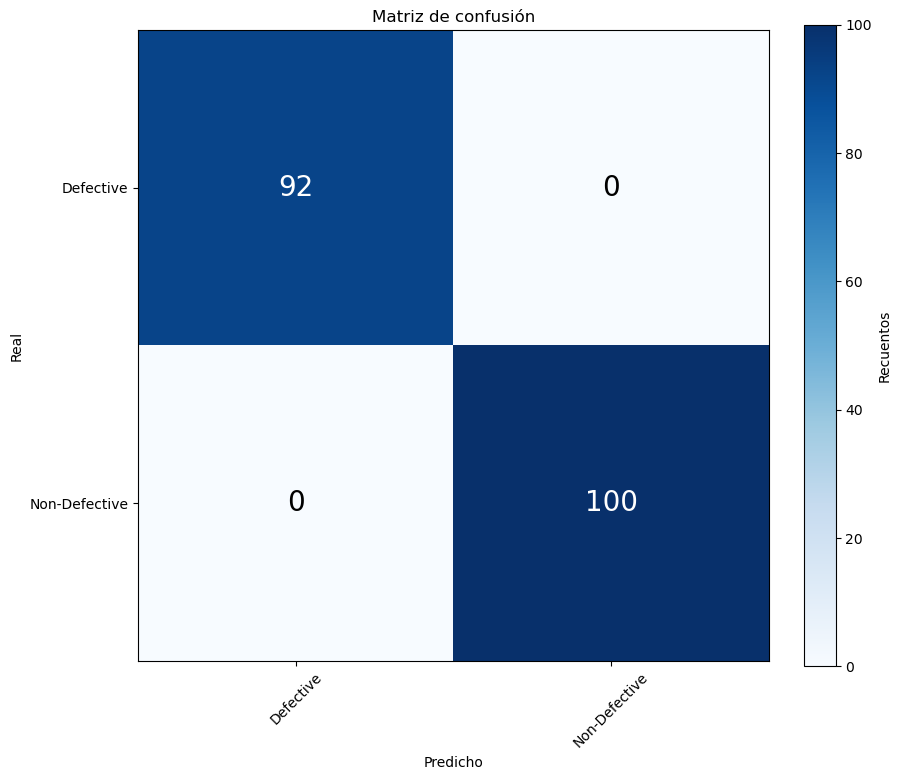

In [15]:
# Para graficar la matriz de confusión
y_real = T.Real
y_predicho = T.PredTest1
clases = ["Defective", "Non-Defective"]
# clases = ["Defectuosas, Sin defecto"] # Sí se requiere que las clases aparezcan en español, descomentar esta línea.
matriz = confusion_matrix(y_real, y_predicho)

figura, ax = plt.subplots(figsize = (9, 9))
img_matriz = ax.imshow(matriz, interpolation = "nearest", cmap = plt.cm.Blues)
plt.title("Matriz de confusión")
plt. colorbar(img_matriz, fraction = 0.046, pad = 0.05, label = "Recuentos")

num_clases = np.arange(len(clases))
plt.xticks(num_clases, clases, rotation = 45)
plt.yticks(num_clases, clases)
plt.xlabel("Predicho")
plt.ylabel("Real")

for i in range(len(clases)):
    for j in range(len(clases)):
        plt.text(j, i, str(matriz[i, j]), 
                 ha = "center", 
                 va = "center", 
                 color = "white" if matriz[i, j] > matriz.max()/ 2 else "black",
                 fontsize = 20
                 )
# print(classification_report(y_real, y_predicho, digits = 4)) # Activar esta línea si se desea ver un reporte con las métricas

plt.show()

### Clasificador CNN para simular proceso con directorios 

In [20]:
##DESCOMENTAR ESTAS LINEAS SI SE DESEA VER EL COMPORTAMIENDO DEL CLASIFICADOR VISUALMENTE
## Las directorios son los mismos que se usan en el método por conteo de píxeles
# dir_entrada = "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/MODELOSAGRUPADOS/DATA/entradas" 
# dir_no_defect = "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/MODELOSAGRUPADOS/DATA/noDefectuosas"
# dir_defect = "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/MODELOSAGRUPADOS/DATA/Defectuosas"

# Batch_size = 16
# Tranformaciones = T.Compose([
#     T.Resize((256,256)),
#     T.ToTensor(),
# ])
# SegmentacionIMG = ImageDataGenerator(rescale = 1./255.00, preprocessing_function = segmentation_semantic_function)

In [22]:
## INICIO DEL PROCESO
# print("Inicio del proceso")

# archivos = listdir(dir_entrada)
# tiempoTotal_ini = t.time()
# for i in range (0, len(archivos), Batch_size):
#     lote_archivos = archivos[i:i+Batch_size]
#     print("********************************")
#     print(f"Procesando lote {i// Batch_size + 1}/{len(archivos)// Batch_size}")
#     lote_images= []
#     tiempo_lote_ini =t.time()
#     for archivo in lote_archivos:
#         muestra_archivo = join(dir_entrada,archivo)
#         img = image.load_img(muestra_archivo, target_size = (256,256))
#         img_prod = SegmentacionIMG.standardize(img)
#         lote_images.append(img_prod)
    
#     lote_images = np.array(lote_images)
#     pred_img = model_7.predict(lote_images)
#     list_pred_clase = np.argmax(pred_img, axis = 1)
    
#     for j, list_pred_clase in zip(lote_archivos, list_pred_clase):
#         if list_pred_clase > 0.5:
#             Salida_pred = join(dir_no_defect, j)
#         else:
#             Salida_pred = join(dir_defect, j)
        
#         shutil.move(join(dir_entrada,j), Salida_pred)
#     tiempo_lote_fin =t.time()
#     tiempo_prom_img = int(((tiempo_lote_fin-tiempo_lote_ini)/Batch_size) * 1000)
#     print(f"Tiempo prom. por img : {tiempo_prom_img} ms")
        
        
# tiempoTotal_fin = t.time()
# Tiempo_total = tiempoTotal_fin - tiempoTotal_ini
# m, s  = divmod(int(Tiempo_total,), 60)
# ms = int((Tiempo_total - int(Tiempo_total)) * 1000)
# print(f"Tiempo de ejecución: {m: .2f} min {s: .2f} s  {ms: .2f} ms")
# print("Proceso terminado")


Inicio del proceso
********************************
Procesando lote 1/12
1/1 [==============================] - 0s 155ms/step
Tiempo prom. por img : 290 ms
********************************
Procesando lote 2/12
1/1 [==============================] - 0s 156ms/step
Tiempo prom. por img : 297 ms
********************************
Procesando lote 3/12
1/1 [==============================] - 0s 166ms/step
Tiempo prom. por img : 305 ms
********************************
Procesando lote 4/12
1/1 [==============================] - 0s 157ms/step
Tiempo prom. por img : 296 ms
********************************
Procesando lote 5/12
1/1 [==============================] - 0s 160ms/step
Tiempo prom. por img : 283 ms
********************************
Procesando lote 6/12
1/1 [==============================] - 0s 169ms/step
Tiempo prom. por img : 293 ms
********************************
Procesando lote 7/12
1/1 [==============================] - 0s 153ms/step
Tiempo prom. por img : 307 ms
**********************

### Método por conteo de píxeles

In [46]:
dir_entrada = "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/MODELOSAGRUPADOS/DATA/entradas" 
# dir_no_defect = "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/MODELOSAGRUPADOS/DATA/noDefectuosas"
# dir_defect = "D:/DETECCION_DE_DEFECTOS/ALGORITHMS_TESIS/MODELOSAGRUPADOS/DATA/Defectuosas

In [51]:
Batch_size = 16
Tranformaciones = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
])

In [56]:
tiempo_ini = t.time()
resultados = []

print("Inicio del proceso")

archivos = listdir(dir_entrada)
for i in range(0, len(archivos),Batch_size):
    lote_archivos = archivos[i:i+Batch_size]
    lote_images= []
    images_nom = []
    for j in lote_archivos:
        muestra_archivo = join(dir_entrada,j)
        img = Image.open(muestra_archivo).convert("RGB")
        img_transform = Tranformaciones(img)
        lote_images.append(img_transform)
        images_nom.append(j)
    lote_images = torch.stack(lote_images)    
    with torch.no_grad():
        Pred_modelo_UNET = model_UNET(lote_images)
        Pred_modelo_UNETD = model_UNET_D2_1(lote_images)
    convert_pred_1 = torch.softmax(Pred_modelo_UNET, dim = 1)
    convert_pred_1_ = torch.argmax(convert_pred_1,dim=1).numpy()
    count_pred1 = np.count_nonzero(convert_pred_1_,axis=(1,2))
    
    convert_pred_2 = torch.softmax(Pred_modelo_UNETD, dim = 1)
    convert_pred_2_ = torch.argmax(convert_pred_2,dim=1).numpy()
    count_pred2 = np.count_nonzero(convert_pred_2_,axis=(1,2))
    
    for k, j in enumerate(lote_archivos):
        
        Total_area_porcentaje =(count_pred2[k]*100)/count_pred1[k]
        
        if Total_area_porcentaje > 10:
#             destino = join(dir_defect, j) 
            prediccion = 0
        else:
#             destino = join(dir_no_defect, j)
            prediccion = 1    
#         shutil.move(muestra_archivo, destino)
        resultados.append([j,prediccion])

tiempo_fin = t.time()
Tiempo_total = tiempo_fin - tiempo_ini
m, s  = divmod(int(Tiempo_total,), 60)
ms = int((Tiempo_total - int(Tiempo_total)) * 1000)
tab_result = pd.DataFrame(resultados, columns=["Nom. archivo","Predicción"])
tab_result.to_excel("PREDMEDPIX.xlsx",index = False)
print(f"Tiempo de ejecución: {m: .2f} min {s: .2f} s  {ms: .2f} ms")
print("Proceso terminado")

Inicio del proceso
Tiempo de ejecución:  1.00 min  26.00 s   676.00 ms
Proceso terminado


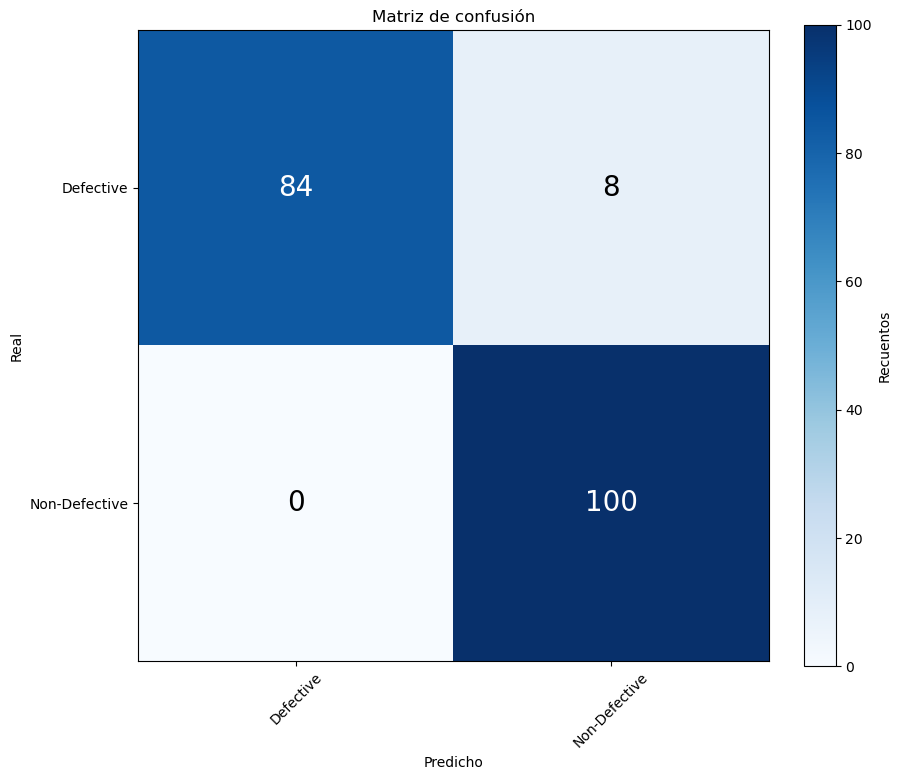

In [58]:
# Para graficar la matriz de confusión
y_real = T.Real
y_predicho_2 = T.PredTest2
clases = ["Defective", "Non-Defective"]
# clases = ["Defectuosas, Sin defecto"] # Sí se requiere que las clases aparezcan en español, descomentar esta línea.
matriz = confusion_matrix(y_real, y_predicho_2)

figura, ax = plt.subplots(figsize = (9, 9))
img_matriz = ax.imshow(matriz, interpolation = "nearest", cmap = plt.cm.Blues)
plt.title("Matriz de confusión")
plt. colorbar(img_matriz, fraction = 0.046, pad = 0.05, label = "Recuentos")

num_clases = np.arange(len(clases))
plt.xticks(num_clases, clases, rotation = 45)
plt.yticks(num_clases, clases)
plt.xlabel("Predicho")
plt.ylabel("Real")

for i in range(len(clases)):
    for j in range(len(clases)):
        plt.text(j, i, str(matriz[i, j]), 
                 ha = "center", 
                 va = "center", 
                 color = "white" if matriz[i, j] > matriz.max()/ 2 else "black",
                 fontsize = 20
                 )
# print(classification_report(y_real, y_predicho_2, digits = 4)) # Activar esta línea si se desea ver un reporte con las métricas

plt.show()